In [13]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
from sklearn.preprocessing import StandardScaler
from gpytorch.means import Mean
from sklearn.metrics import mean_squared_error
from gpytorch.kernels import Kernel, RBFKernel,ScaleKernel
from gpytorch.constraints import Interval
from gpytorch.settings import cholesky_jitter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import torch.nn as nn
import logging
from itertools import product
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset,TensorDataset
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:


# df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
# X_df = df[['param_1', 'param_2', 'param_3',
#        'param_4','ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
#        'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
#        'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
#        'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
#        'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
#        'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
#        'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']]
# y_df = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
#        'norm_cells_4', 'norm_cells_5']]





# X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=0.1, random_state=42)

def load_dataset(X_path,y_path,X_domain_path=None,do_standardisation=False,test_size=0.2,random_state=42):
    X_df=None
    X_domain_info=None
    y_df=None
    with open(X_path, 'rb') as f:
        X_df = pickle.load(f)
    with open(y_path, 'rb') as f:
        y_df = pickle.load(f)
    print(X_df.shape)
    print(y_df.shape)
    if X_domain_path!=None:
        with open(X_domain_path, 'rb') as f:
            X_domain_info = pickle.load(f)
        X_train, X_test, y_train, y_test,X_D_train,X_D_test = train_test_split(X_df, y_df,X_domain_info, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=test_size, random_state=random_state)
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)

    if X_domain_path!=None:
        X_D_train = np.array(X_D_train, dtype=np.float32)
        X_D_test = np.array(X_D_test, dtype=np.float32)

    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    if do_standardisation:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    if X_domain_path!=None:
        X_D_train_tensor = torch.tensor(X_D_train)
        X_D_test_tensor = torch.tensor(X_D_test)

    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    if X_domain_path!=None: 
        return (X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)
    else:
        return (X_train_tensor,y_train_tensor),(X_test_tensor,y_test_tensor)
    
# X_path="data/X_df_toy.pkl"
# y_path="data/y_df_toy.pkl"

X_path="data/X_df_Shikonin.pkl"
y_path="data/y_df_Shikonin.pkl"



X_domain_path=""
(X_train_tensor,y_train_tensor),(X_test_tensor,y_test_tensor)=load_dataset(X_path,y_path)


num_conc=y_train_tensor.shape[1]

num_feat=X_train_tensor.shape[1]

USE_TOY_DATASET=True

if USE_TOY_DATASET:

    # Training data is 100 points in [0,1] inclusive regularly spaced
    X_train_tensor = torch.linspace(0, 1, 100)
    # True function is sin(2*pi*x) with Gaussian noise
    y_train_tensor = torch.sin(X_train_tensor * (2 * math.pi)) + torch.randn(X_train_tensor.size()) * math.sqrt(0.04)

    num_conc=1
    num_feat=1





(274, 1084)
(274, 10)


In [15]:
print(X_test_tensor.shape)
print(X_train_tensor.shape)

torch.Size([55, 1084])
torch.Size([100])


In [16]:
with open(X_path, 'rb') as f:
    X_df = pickle.load(f)
mask_bool_met = X_df.columns.str.contains("HypMET")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)
print("MUT features:"+str(np.sum(mask_float_mut)))
print("Met features:"+str(np.sum(mask_float_met)))
print("CNA features:"+str(np.sum(mask_float_cna)))
print("DC features:"+str(np.sum(mask_float_dc)))

MUT features:310.0
Met features:338.0
CNA features:425.0
DC features:0.0


In [17]:
class QuadripleDRPKernel(Kernel):
    def __init__(self,filters, **kwargs):
        super().__init__(**kwargs)
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        # self.kernel_dc = gpytorch.kernels.RBFKernel()
        self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=self.filter_mu
        filter_met=self.filter_met
        filter_cn=self.filter_cn
        filter_dc=self.filter_dc
        
        x1_mu   =   x1 @ filter_mu
        x1_met  =   x1 @ filter_met
        x1_cn   =   x1 @ filter_cn
        x1_dc   =   x1 @ filter_dc

        x2_mu   =   x2 @ filter_mu
        x2_met  =   x2 @ filter_met
        x2_cn   =   x2 @ filter_cn
        x2_dc   =   x2 @ filter_dc
        bias=torch.ones(x1.shape[0], x2.shape[0])
        return self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1#self.kernel_dc(x1_dc,x2_dc)

In [18]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,filters, likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
           QuadripleDRPKernel(filters), num_tasks=num_conc
        )
        
        if USE_TOY_DATASET:
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_conc])), num_tasks=num_conc
            )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class Linear_Model_Of_Corregionalization(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,likelihood,):
        super(Linear_Model_Of_Corregionalization, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        kernels=[]
        for _ in range(num_conc):
            kernels.append(RBFKernel())

        self.covar_module =gpytorch.kernels.LCMKernel(
            kernels, num_tasks=num_conc, rank=num_conc
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [26]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = Linear_Model_Of_Corregionalization(X_train_tensor, y_train_tensor, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.18)

# 定义学习率调度器 (每50个epoch衰减一次学习率)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
last_loss=1
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    this_loss=loss.item()
    optimizer.step()  # 更新参数
    scheduler.step()  # 更新学习率
    if abs((last_loss-this_loss)/last_loss)<0.001:
        pass
    last_loss=this_loss

Iter 1/200 - Loss: 1.198
Iter 2/200 - Loss: 1.134
Iter 3/200 - Loss: 1.069
Iter 4/200 - Loss: 0.996
Iter 5/200 - Loss: 0.918
Iter 6/200 - Loss: 0.843
Iter 7/200 - Loss: 0.775
Iter 8/200 - Loss: 0.707
Iter 9/200 - Loss: 0.638
Iter 10/200 - Loss: 0.566
Iter 11/200 - Loss: 0.492
Iter 12/200 - Loss: 0.417
Iter 13/200 - Loss: 0.343
Iter 14/200 - Loss: 0.273
Iter 15/200 - Loss: 0.208
Iter 16/200 - Loss: 0.151
Iter 17/200 - Loss: 0.096
Iter 18/200 - Loss: 0.042
Iter 19/200 - Loss: -0.006
Iter 20/200 - Loss: -0.046
Iter 21/200 - Loss: -0.075
Iter 22/200 - Loss: -0.095
Iter 23/200 - Loss: -0.106
Iter 24/200 - Loss: -0.108
Iter 25/200 - Loss: -0.103
Iter 26/200 - Loss: -0.093
Iter 27/200 - Loss: -0.078
Iter 28/200 - Loss: -0.063
Iter 29/200 - Loss: -0.050
Iter 30/200 - Loss: -0.043
Iter 31/200 - Loss: -0.042
Iter 32/200 - Loss: -0.047
Iter 33/200 - Loss: -0.057
Iter 34/200 - Loss: -0.069
Iter 35/200 - Loss: -0.081
Iter 36/200 - Loss: -0.091
Iter 37/200 - Loss: -0.100
Iter 38/200 - Loss: -0.107
I

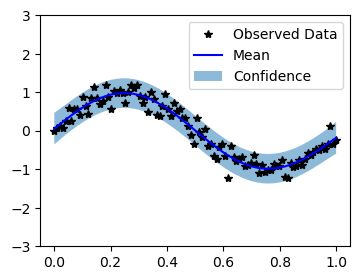

In [27]:
if USE_TOY_DATASET == True:
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, 1, 51)
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(X_train_tensor.numpy(), y_train_tensor.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:

# Set into eval mode
model.eval()
likelihood.eval()

random_num = np.random.randint(0, len(X_test_tensor), size=1)[0]
y_true=y_test_tensor

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    distribution = likelihood(model(X_test_tensor))
    mean = distribution.mean
    lower, upper = distribution.confidence_region()


x_plt_axis = torch.tensor(range(num_conc))

# print(x_plt_axis.shape)
# print(mean[0][0].shape)
print("Num "+str(random_num)+" Chosen for display")
# 创建图形、
# print(mean.flatten())

plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, mean[random_num], label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true[random_num], label='True', color='red')
plt.fill_between(x_plt_axis, lower[random_num], upper[random_num], alpha=0.5)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylim(-0.5, 1.5)
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)



RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1 but got size 1084 for tensor number 1 in the list.

In [ ]:
rmse=torch.sqrt(torch.tensor(mean_squared_error(y_test_tensor.numpy(), mean.numpy()))).item() 
nll = -torch.distributions.Normal(mean, distribution.variance.sqrt()).log_prob(y_test_tensor).mean().item()
nmse = rmse / torch.var(y_test_tensor).item()

print(f'RMSE: {rmse:.4f}')
print(f'NLL: {nll:.4f}')
print(f'NMSE: {nmse:.4f}')

RMSE: 0.2072
NLL: -0.8667
NMSE: 0.2100
